In [9]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

In [11]:
%matplotlib inline

In [12]:
TEXT_COLOUR = {
    'PURPLE':'\033[95m',
    'CYAN':'\033[96m',
    'DARKCYAN':'\033[36m',
    'BLUE':'\033[94m',
    'GREEN':'\033[92m',
    'YELLOW':'\033[93m',
    'RED':'\033[91m',
    'BOLD':'\033[1m',
    'UNDERLINE':'\033[4m',
    'END':'\033[0m'
}

def print_bold(*msgs):
    print(TEXT_COLOUR['BOLD'])
    print(*msgs)
    print(TEXT_COLOUR['END'])

def print_green(*msgs):
    print(TEXT_COLOUR['GREEN'])
    print(*msgs)
    print(TEXT_COLOUR['END'])

def print_error(*msgs):
    print(TEXT_COLOUR['RED'])
    print(*msgs)
    print(TEXT_COLOUR['END'])

def wrap_green(msg):
    return TEXT_COLOUR['GREEN'] + msg + TEXT_COLOUR['END']

def wrap_red(msg):
    return TEXT_COLOUR['RED'] + msg + TEXT_COLOUR['END']

def up_down_str(val):
    msg = str(val)
    if val > 0:
        msg = wrap_green(msg)
    elif val < 0:
        msg = wrap_red(msg)
    return msg

In [13]:
exp='roberta-large'
num_layers = 24

In [14]:
tasks = ["CoLA","SST-2","MRPC","STS-B","QQP","MNLI", "MNLI-MM", "QNLI","RTE"]
tasks = ["CoLA","MRPC","STS-B","RTE"]

metrics = {
    "CoLA":["mcc"],
    "MNLI":["acc"],
    "MNLI-MM":["acc"],
    "MRPC":["f1"],
    "QNLI":["acc"],
    "QQP":["f1"],
    "RTE":["acc"],
    "SST-2":["acc"],
    "STS-B":["spearmanr"],
    "WNLI":["acc"] #temp
}

reported_in_paper = {
    "CoLA":0.00,
    "MNLI":0.00,
    "MNLI-MM":0.0,
    "MRPC":0.00,
    "QNLI":0.00,
    "QQP":0.00,
    "RTE":0.00,
    "SST-2":0.00,
    "STS-B":0.00,
    "WNLI":0.00
}

In [15]:

def get_average_val(lines):
    reported = []
    for line in lines:
        print('\t', line)
        val = float(line.split('\t')[1])
        if val != 0:
            reported.append(val)
    out = 0
    if len(reported) != 0:
        reported.sort(reverse = True)
        candidates = [reported[0]]
        for j in range(1, len(reported)):
            if reported[j] > 0.9 * reported[0]:
                candidates.append(reported[j])
        out = np.mean(candidates)
        
    return out


In [16]:
results = {}

for task in tasks:
    task_results = {}
    task_metrics = metrics[task]
    for metric in task_metrics:
        
        # base metrics
        print(f"../exp_results/{exp}/{task}/base-{metric}.txt")
        f=open(f"../exp_results/{exp}/{task}/base-{metric}.txt", "r")
        lines = f.read().splitlines()
        task_results[f'base-{metric}'] = get_average_val(lines)
        
        # no layer metrics
        
        fine_tuning_metrics = []
        print(f"../exp_results/{exp}/{task}/no_layer-{metric}.txt")
        f=open(f"../exp_results/{exp}/{task}/no_layer-{metric}.txt", "r")

        lines = f.read().splitlines()
        fine_tuning_metrics.append(get_average_val(lines))
        
        # fine-tuned metrics
        
        log_file_prefix=''
        for i in reversed(range(int(num_layers/2), num_layers)):
            log_file_prefix += str(i)
            f=open(f"../exp_results/{exp}/{task}/{log_file_prefix}-{metric}.txt", "r")
            lines = f.read().splitlines()
            print(i)
            fine_tuning_metrics.append(get_average_val(lines))
            
            log_file_prefix +='_'
        
        task_results[f'{metric}'] = list(reversed(fine_tuning_metrics))
        
    results[task] = task_results

../exp_results/roberta-large/CoLA/base-mcc.txt
	 11	0.665357196937062
	 12	0.6555128829335255
	 13	0.6609225600006813
	 14	0.6362621815348365
	 15	0.6870284696189455
../exp_results/roberta-large/CoLA/no_layer-mcc.txt
	 1	0.0
	 2	0.0
	 3	0.0
	 4	0.0
	 5	0.0
	 6	0.0
23
	 1	0.49383134457499944
	 2	0.480655898219179
	 3	0.4913288678758369
	 4	0.48314426803731003
	 5	0.49111842502686537
	 6	0.5079531963854501
22
	 1	0.5496129885311101
	 2	0.5449141719492956
	 3	0.5260499940984096
	 4	0.5365007161029405
	 5	0.562537539158554
	 6	0.5528800923802824
21
	 1	0.6037376215490442
	 2	0.5782054486858687
	 3	0.5756584003915552
	 4	0.5829069963924198
	 5	0.5930546484314362
	 6	0.6059691562850315
20
	 1	0.6032121451400153
	 2	0.5880199146512337
	 3	0.5829211024374039
	 4	0.5908413057707468
	 5	0.5786416039440073
	 6	0.6157026456344282
19
	 1	0.585467058423594
	 2	0.6081727293932068
	 3	0.6031588333778671
	 4	0.6207194911624668
	 5	0.598349211554662
	 6	0.5880544551678445
18
	 1	0.5812018675459495
	 2	0

In [17]:
x_axis = []

for i in range(int(num_layers/2), num_layers):
    x_axis.append(str(i))

x_axis.append("none")

In [18]:
def draw_graph(task, y_label, paper, base, reported):
    plt.figure(figsize=(10,6))
    plt.plot(x_axis, reported)
    
    plt.xlabel("layers")
    plt.ylabel(y_label)
    
    if paper == 0.0:    
        gap = max(reported) - min(reported)
        top = max(max(reported), base) + (gap*0.2)
        bottom = min(min(reported), base) - (gap*0.2)
    
        plt.ylim(bottom, top)

        plt.axhline(y=base, linestyle='--', c='green')
    else:
        gap = max(reported) - min(reported)
        top = max(max(reported), base, paper) + (gap*0.2)
        bottom = min(min(reported), base, paper) - (gap*0.2)
    
        plt.ylim(bottom, top)

        plt.axhline(y=base, linestyle='--', c='green')
        plt.axhline(y=paper, linestyle='--', c='red')
    
    plt.title(f'{exp}-{task} ({round(base,4)})')
    plt.savefig(f'images/{exp}/{task}', format='png', bbox_inches='tight')
    plt.show()


CoLA mcc

	base : 66.1
	50% : 62.12
	none : 0


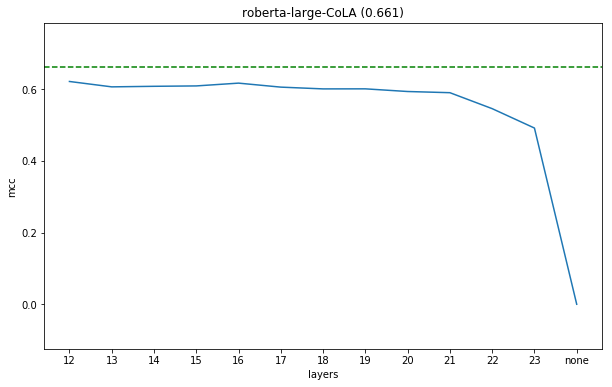


MRPC f1

	base : 92.21
	50% : 92.71
	none : 81.22


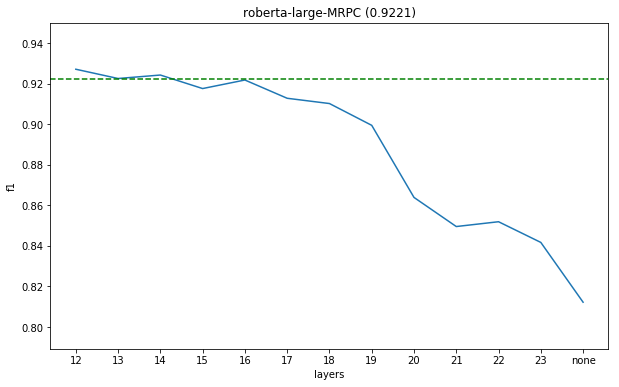


STS-B spearmanr

	base : 91.99
	50% : 91.03
	none : 11.19


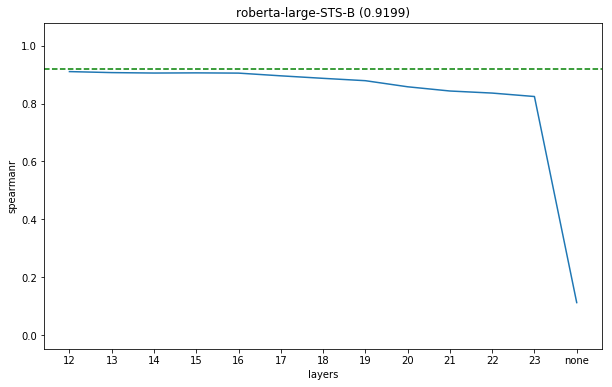


RTE acc

	base : 84.04
	50% : 82.02
	none : 48.3


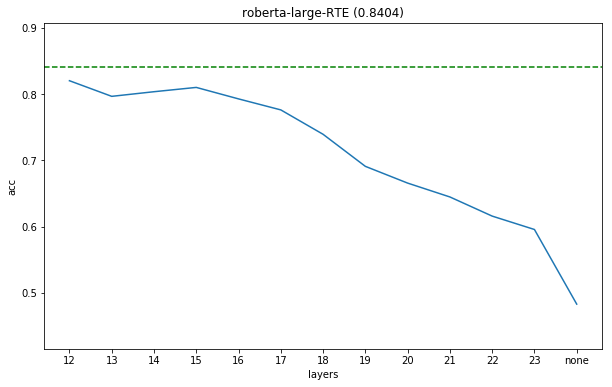

In [20]:
for task in tasks:
    task_results = results[task]
    task_metrics = metrics[task]
    for metric in task_metrics:
        reported = task_results[metric]
        base = task_results[f'base-{metric}']
        print_bold(task, metric)
        print(f"\tbase : {round(base * 100, 2)}")
        print(f"\t50% : {round(task_results[metric][0] * 100, 2)}")
        print(f"\tnone : {round(task_results[metric][-1] * 100, 2)}")
#         draw_graph(task, metric, reported_in_paper[task], base, reported)